# Inference Example 
This notebook dempnstrates how to do inference using the SFCN model for AD-vs-HC classification. 

By default this notebooks demonstates inference on the IXI dataset, since ADNI is available only to researchers.

Make sure that the preprocessing has been performed using the `preprocessing.ipynb` notebook.

In [1]:
import torch

from monai.data import DataLoader, Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    Spacingd,
    ResizeWithPadOrCropd,
    ScaleIntensityd,
)

from pathlib import Path
import json

from SFCN import SFCN, get_Bb_dims

import numpy as np
import matplotlib.pyplot as plt

In [2]:
fold = 1

pixdim = (1.0, 1.0, 1.0)
img_size = (160, 192, 160)

batch_size = 1
dataloader_workers = 0 # 0 means no subprocesses

In [3]:
static_transform = Compose(
    [
        LoadImaged(keys=['image']),
        EnsureChannelFirstd(keys=['image']),
        CropForegroundd(keys=["image"], source_key="image"),
        Spacingd(keys=['image'], pixdim=pixdim, mode=("bilinear")),
        ResizeWithPadOrCropd(keys=['image'], spatial_size=img_size, mode='constant', value=0.0),
        ScaleIntensityd(keys=["image"], minv=0.0, maxv=1.0),
    ])

In [4]:
# Load the dataset
dataset_path = Path('.')
json_path = dataset_path / 'IXI_preprocessed.json'

with open(json_path, 'r') as f:
    dataset = json.load(f)


# Initialize the dataloader
dataset = Dataset(dataset, transform=static_transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=dataloader_workers)

# Initilize the B7 version of SFCN with 1 output channel
model = SFCN(get_Bb_dims(7), 1)

# Load the weights
model_weights_path = Path('model_weights') / f'SFCN_AD_fold{fold}.pt'
model.load_state_dict(torch.load(model_weights_path), strict=True)


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mdoel = model.to(device)


## Do inference on the Dataset and save the results

In [5]:
n_lim = 5 # Number of images to process
images = []
outputs = []

for i, batch in enumerate(dataloader):
    if i >= n_lim:
        break
    
    image = batch['image'].to(device)

    output = model(image)
    output = torch.sigmoid(output)

    images.append(image.cpu().detach().numpy())
    outputs.append(output[0, 0].cpu().detach().numpy())



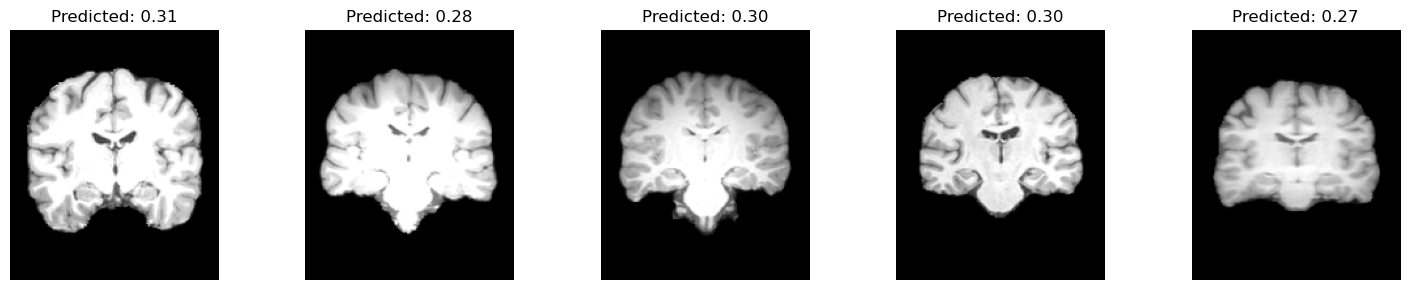

In [6]:
# Plot the images with the predicted labels
cols = 5
rows = np.ceil(n_lim / cols).astype(int)
fig, axs = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

for i in range(n_lim):
    if axs.ndim == 1:
        ax = axs[i]
    else:
        ax = axs[i // cols, i % cols]
    img = images[i]
    output = outputs[i]
    image = img[0, 0, 80, :, :]
    image = np.flip(image, axis=0)
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Predicted: {output:.2f}')
    ax.axis('off')
    
fig.tight_layout()